In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime

In [76]:
# Import custom functions to extract our Image arrays and Pixel Mask arrays from our created fits files dataset
from dataGathering import extractImageArray, extractPixelMaskArray, extract_star_catalog
from dataGathering import getStarData, getCoordRangeFromPixels, getStarsInImage, getPixelCoordsFromStar, getImagePlot, getPixelMaskPlot
from dataGathering import displayRawImage, displayRawPixelMask, displayImagePlot, displayPixelMaskPlot, displayPixelMaskOverlayPlot

# Import custom function to preprocess Image and Pixel Mask arrays
from imageProcessing import normalizeImages, stackImages, stackMasks, preprocessImage

# Import astropy to read fits files, and os to interact with the file system
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
import os

In [77]:
# getStarData('II/246', 50, 'validate')

In [78]:
# Create images and masks arrays lists
images = []
masks = []

# Create a list of all the wcs data in the dataset folder
wcs_data = []

# Create a dataframe to store the star data inside each fits file
stars_table = []

# Create df to store the star data inside each fits file
stars_in_image = []

# Create a list of all the fits files in the dataset folder
fits_files = os.listdir('data/fits/')
fits_files = [file for file in fits_files if file.startswith('validate')]

# For all the fits files in the dataset folder specified in file_path, extract the image and mask arrays to the respective lists
file_path = 'data/fits/'
for file in os.listdir(file_path):
    if file.endswith('.png'):
        os.remove(file_path + file)
    if file.startswith('validate') and file.endswith('.fits'):
        images.append(extractImageArray(file_path + file))
        masks.append(extractPixelMaskArray(file_path + file))
        wcs = wcs_data.append(WCS(fits.open(file_path + file)[0].header))
        stars_table.append(extract_star_catalog(file_path + file))
        stars_in_image.append(getStarsInImage(wcs, extract_star_catalog(file_path + file).to_pandas(), getCoordRangeFromPixels(WCS(fits.open(file_path + file)[0].header))))

        print(file + ' added to dataset')

Number of stars in catalog query:  3967
validate16.fits added to dataset
Number of stars in catalog query:  4186
validate11.fits added to dataset
Number of stars in catalog query:  562
validate37.fits added to dataset
Number of stars in catalog query:  627
validate29.fits added to dataset
Number of stars in catalog query:  1434
validate38.fits added to dataset
Number of stars in catalog query:  937
validate24.fits added to dataset
Number of stars in catalog query:  928
validate18.fits added to dataset
Number of stars in catalog query:  1212
validate35.fits added to dataset
Number of stars in catalog query:  480
validate20.fits added to dataset
Number of stars in catalog query:  640
validate14.fits added to dataset
Number of stars in catalog query:  2997
validate43.fits added to dataset
Number of stars in catalog query:  689
validate25.fits added to dataset
Number of stars in catalog query:  621
validate12.fits added to dataset
Number of stars in catalog query:  2741
validate31.fits add

In [79]:
# extractImageArray(file_path + fits_files[0])

In [80]:
# displayImagePlot(file_path + fits_files[0])

In [81]:
# displayRawImage(file_path + fits_files[0])

In [82]:
# displayRawPixelMask(file_path + fits_files[0])

In [83]:
# displayPixelMaskPlot(file_path + fits_files[0])

In [84]:
# displayPixelMaskOverlayPlot(file_path + fits_files[0])

In [85]:
images[0].shape

(512, 512)

In [86]:

# images_processed = []
# for image in images:
#     images_processed.append(preprocessImage(image))

# images_processed = np.array(images_processed)


images_processed = images

In [87]:
# Convert to 3-channel images,   Copilot advises the above (axis=-1) is the correct way to stack the images and masks, if incorrect do below:
# "For most convolutional neural networks (CNNs), the expected input shape for images is typically (height, width, channels). Therefore, you should aim to have each image in the shape (512, 512, 3)" ##
# new_images = np.array([np.stack([image, image, image], axis=-1) for image in images])
# new_masks = np.array([np.expand_dims(mask, axis=-1) for mask in masks])

# #### If the above code does not work, use the below code to stack the images and masks
# # new_images = np.array([np.stack([image, image, image], axis=0) for image in images])
# # new_masks = np.array([np.stack([mask, mask, mask], axis=0) for mask in masks])



# # Convert the list to a NumPy array,   Copilot advises that model training desired 
# ## "The model training or validation typically expects a NumPy array of images. The ImageDataGenerator from Keras can accept NumPy arrays as input" ##
# new_images = np.array(new_images)
# new_masks = np.array(new_masks)


new_images = stackImages(images_processed)
new_masks = stackMasks(masks)

print(new_images[0].shape)
print(new_images.shape)
print(type(new_images))


(50, 512, 512, 3)
(50, 512, 512, 1)
(512, 512, 3)
(50, 512, 512, 3)
<class 'numpy.ndarray'>


In [88]:
# Find the minimum and maximum values in the dataset
# min_val = np.min(new_images)
# max_val = np.max(new_images)

# # Apply min-max normalization
# new_images_normalized = (new_images - min_val) / (max_val - min_val)

# print(new_images_normalized.min(), new_images_normalized.max())  # Should be 0.0 and 1.0

new_images_normalized = normalizeImages(new_images)

137.0 20706.0
Normalized min: 0.0, max: 1.0


# Checking if dataset is too large to load into predictions without batches.

In [89]:
import numpy as np
import psutil

# Example parameters
num_images = 1000  # Replace with the actual number of images
image_shape = (512, 512, 3)
mask_shape = (512, 512, 1)
dtype_size = 4  # Size of float32 in bytes

# Calculate the size of one image and one mask
image_size = np.prod(image_shape) * dtype_size
mask_size = np.prod(mask_shape) * dtype_size

# Calculate the total size of the dataset
total_size_in_bytes = num_images * (image_size + mask_size)
total_size_in_mb = total_size_in_bytes / (1024 * 1024)

# Check available system memory
available_memory_in_mb = psutil.virtual_memory().available / (1024 * 1024)

print(f"Total dataset size: {total_size_in_mb:.2f} MB")
print(f"Available system memory: {available_memory_in_mb:.2f} MB")

# Determine if the dataset is too large to load into memory
if total_size_in_mb > available_memory_in_mb * 0.8:  # Leave some room for other processes
    print("The dataset is too large to load into memory without using batches.")
else:
    print("The dataset can be loaded into memory without using batches.")

Total dataset size: 4000.00 MB
Available system memory: 1214.83 MB
The dataset is too large to load into memory without using batches.


In [90]:
# Create an ImageDataGenerator for normalization (no augmentation needed for prediction)
datagen = ImageDataGenerator()

# Define batch size
batch_size = 4

# Create generators for the new images and masks
new_image_generator = datagen.flow(new_images_normalized, batch_size=batch_size, shuffle=False)
new_mask_generator = datagen.flow(new_masks, batch_size=batch_size, shuffle=False)

# Custom generator to yield images and masks together
def custom_generator(image_generator, mask_generator):
    while True:
        image_batch = next(image_generator)
        mask_batch = next(mask_generator)
        yield (image_batch, mask_batch)

# Combine the image and mask generators
new_data_generator = custom_generator(new_image_generator, new_mask_generator)

## Choose the correct model from below:

In [91]:
# Display all the models in the models folder
saved_models_path = 'models/saved_models/'
model_files = os.listdir(saved_models_path)
model_files = [file for file in model_files if file.endswith('.keras')]
model_files

['2024_10_27-2206_200_unet_model.keras',
 '2024_10_27-2040_200_unet_model.keras',
 '2024_10_25-0131_100unet_model_.keras',
 '2024_10_25-0131_100unet_model.keras',
 '2024_10_25-0131_150unet_model_.keras',
 '2024_10_25-0131_10_unet_model_.keras']

In [92]:
# Load the saved model
model_choice = '2024_10_25-0131_150unet_model_.keras'
model = load_model(saved_models_path + model_choice)

In [93]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(new_data_generator, steps=len(new_images_normalized) // batch_size, verbose=1)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9958 - loss: 0.6417
Test Loss: 0.64163738489151
Test Accuracy: 0.9962357878684998


In [94]:
# Plot the loss and accuracy curves for the training and validation sets
def plot_metrics(history):
    # Define the figure and axis
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the loss
    ax[0].plot(history.history['loss'], label='Training Loss')
    ax[0].plot(history.history['val_loss'], label='Validation Loss')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    # Plot the accuracy
    ax[1].plot(history.history['accuracy'], label='Training Accuracy')
    ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[1].set_title('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    # Display the plots
    plt.tight_layout()
    # plt.savefig('results/figures/' + model_choice + '_loss_accuracy_plot.png')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2028.0 14401.0
Normalized min: 0.0, max: 1.0


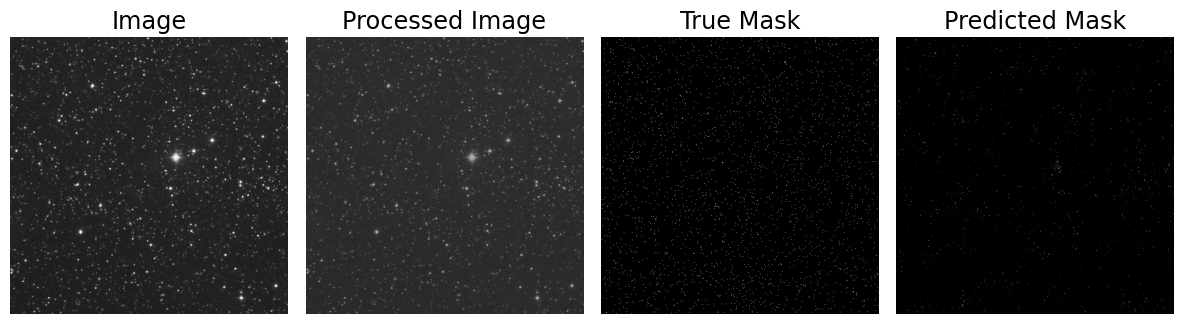

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1785.0 18793.0
Normalized min: 0.0, max: 1.0


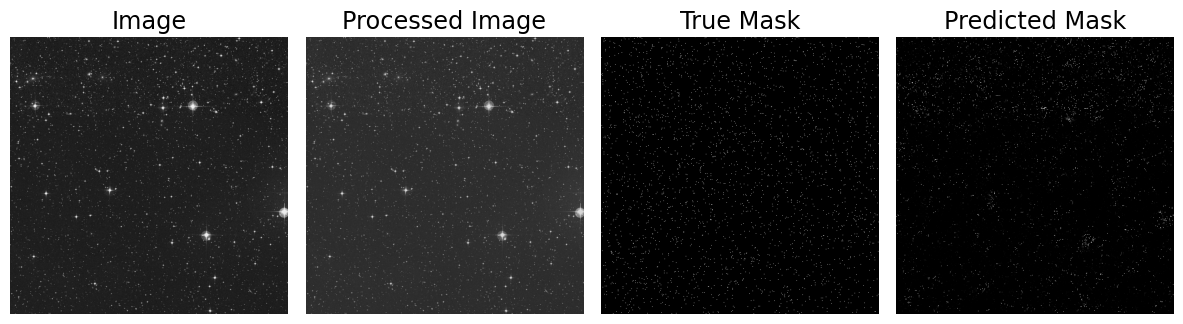

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1535.0 15963.0
Normalized min: 0.0, max: 1.0


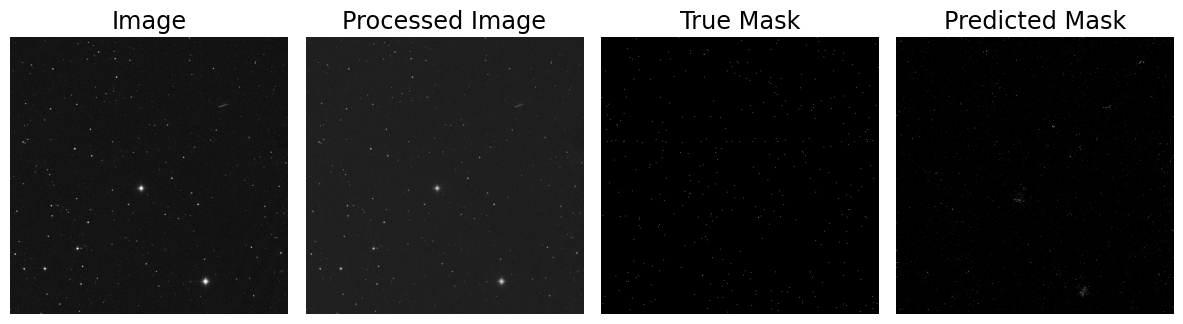

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1225.0 15783.0
Normalized min: 0.0, max: 1.0


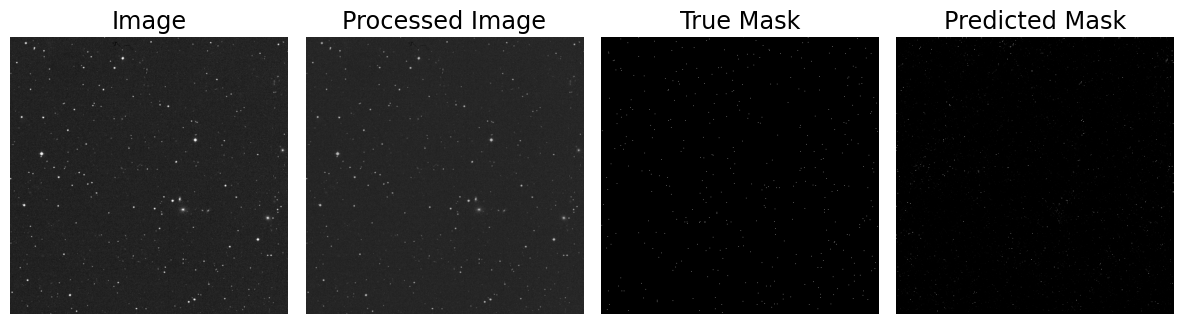

In [100]:
# Plot the results from the model
for i in range(4):
    image = images[i]
    new_image = new_images[i]
    normalized_image = new_images_normalized[i]
    mask = new_masks[i]
    pred_mask = model.predict(np.expand_dims(new_image, axis=0))[0]

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 4, 1)
    plt.imshow(normalizeImages(new_image), cmap='gray')
    plt.axis('off')
    plt.title('Image')

    plt.subplot(1, 4, 2)
    plt.imshow(normalized_image)
    plt.axis('off')
    plt.title('Processed Image')

    plt.subplot(1, 4, 3)
    plt.imshow(mask[:, :, 0], cmap='gray')
    plt.axis('off')
    plt.title('True Mask')

    plt.subplot(1, 4, 4)
    plt.imshow(pred_mask[:, :, 0], cmap='gray')
    plt.axis('off')
    plt.title('Predicted Mask')

    plt.tight_layout()
    plt.show()

In [56]:
# Make predictions on new data
predictions = model.predict(new_data_generator, steps=len(new_images) // batch_size)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


In [59]:
#Create a function to plot the image, mask and prediction side by side
def plot_image_mask_prediction_subplot(selection = 0):
    """
    Plots the image, mask, and prediction for a given selection index.
    Parameters:
    selection (int): The index of the image, mask, and prediction to plot. Default is 0.
    The function extracts the image, mask, and prediction arrays using the provided selection index.
    It then creates a figure with three subplots, each displaying the image, mask, and prediction respectively.
    The subplots are displayed with WCS (World Coordinate System) projection and labeled with RA (Right Ascension) and Dec (Declination).
    """
    image = new_images[selection]
    mask = new_masks[selection]
    pred_mask = model.predict(np.expand_dims(image, axis=0))[0]
    # Normalize the prediction mask to be between 0 and 1
    pred_mask_normalized = (pred_mask - pred_mask.min()) / (pred_mask.max() - pred_mask.min())
    wcs = wcs_data[selection]

    fig, ax = plt.subplots(1, 3, figsize=(30, 10), subplot_kw={'projection': wcs})
    ax[0].imshow(image, cmap='gray', origin='lower')
    ax[0].set_title('Image')
    ax[0].coords.grid(True, color='white', ls='solid')
    ax[0].coords[0].set_axislabel('RA')
    ax[0].coords[1].set_axislabel('Dec')

    ax[1].imshow(mask[:, :, 0], cmap='gray', origin='lower')
    ax[1].set_title('Mask')
    ax[1].coords.grid(True, color='white', ls='solid')
    ax[1].coords[0].set_axislabel('RA')
    ax[1].coords[1].set_axislabel('Dec')

    ax[2].imshow(pred_mask_normalized[:, :, 0], cmap='gray', origin='lower')
    ax[2].set_title('Prediction')
    ax[2].coords.grid(True, color='white', ls='solid')
    ax[2].coords[0].set_axislabel('RA')
    ax[2].coords[1].set_axislabel('Dec')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1785.0..18793.0].


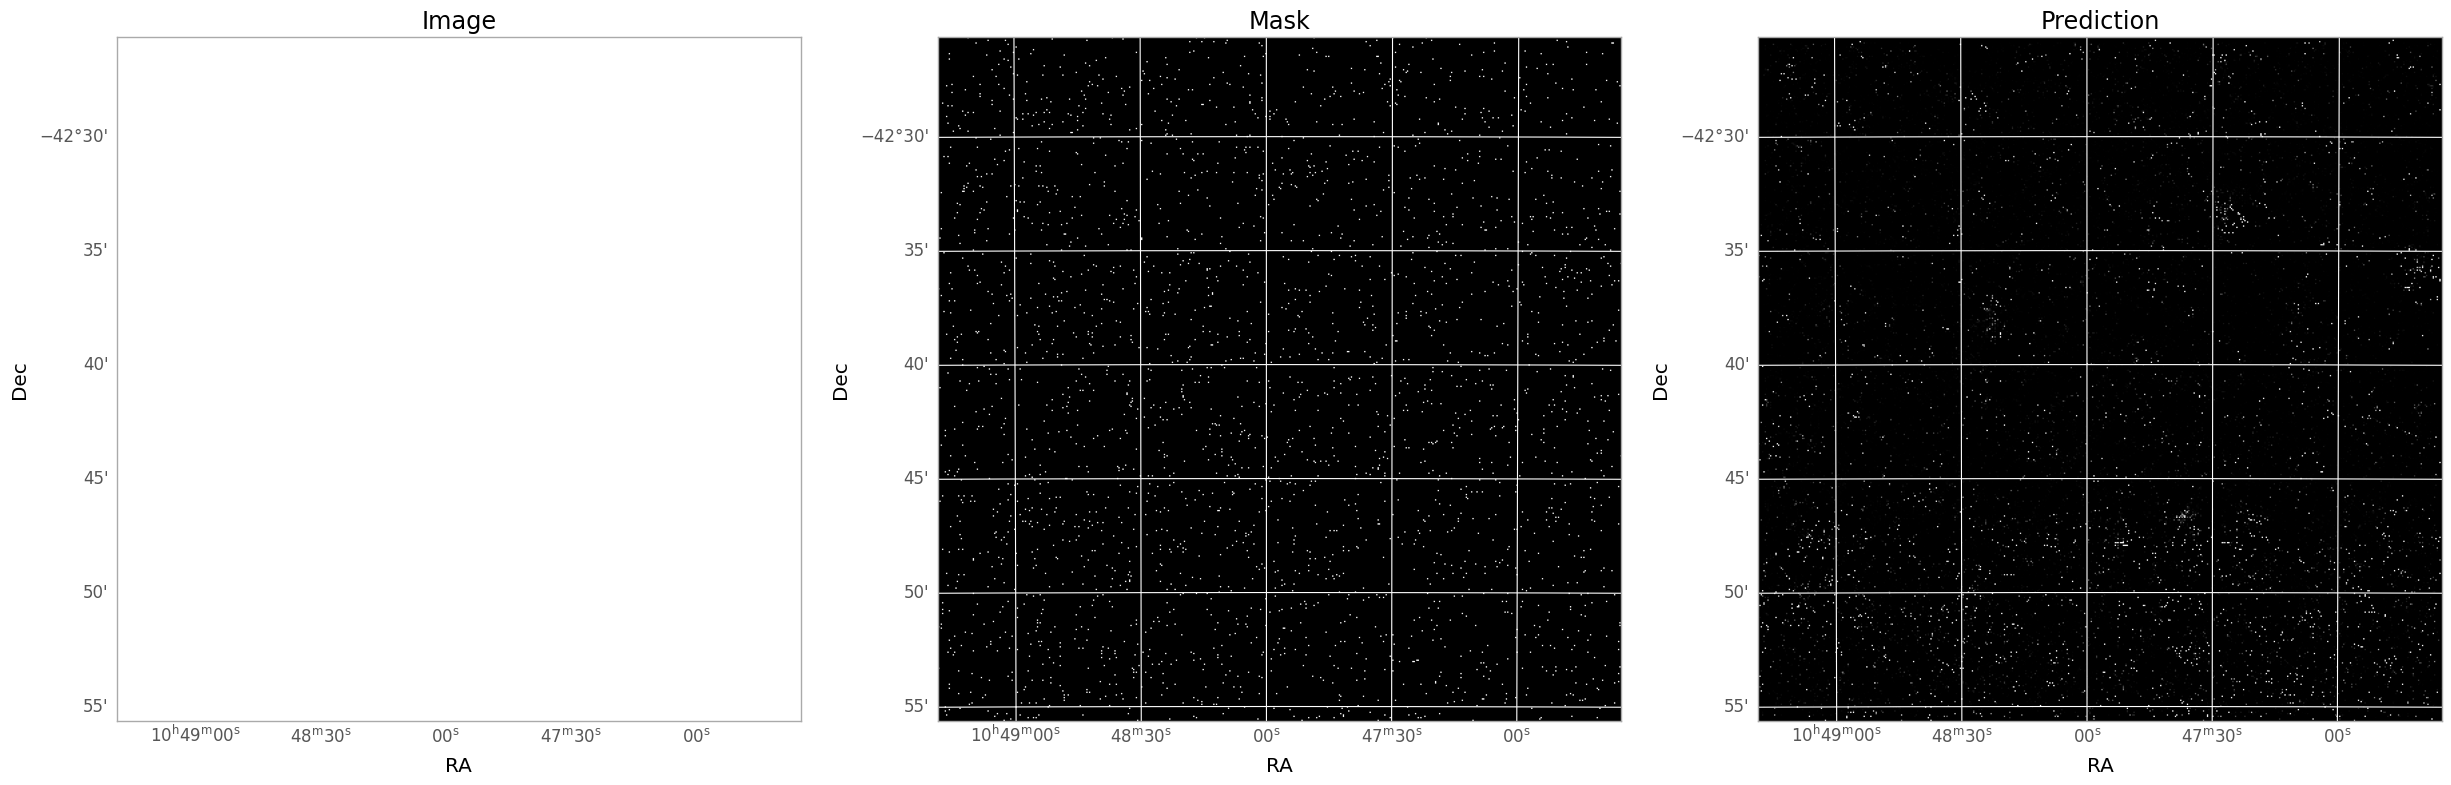

In [60]:
#Plot the 3rd image, mask and prediction
plot_image_mask_prediction_subplot(1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [708.0..19096.0].


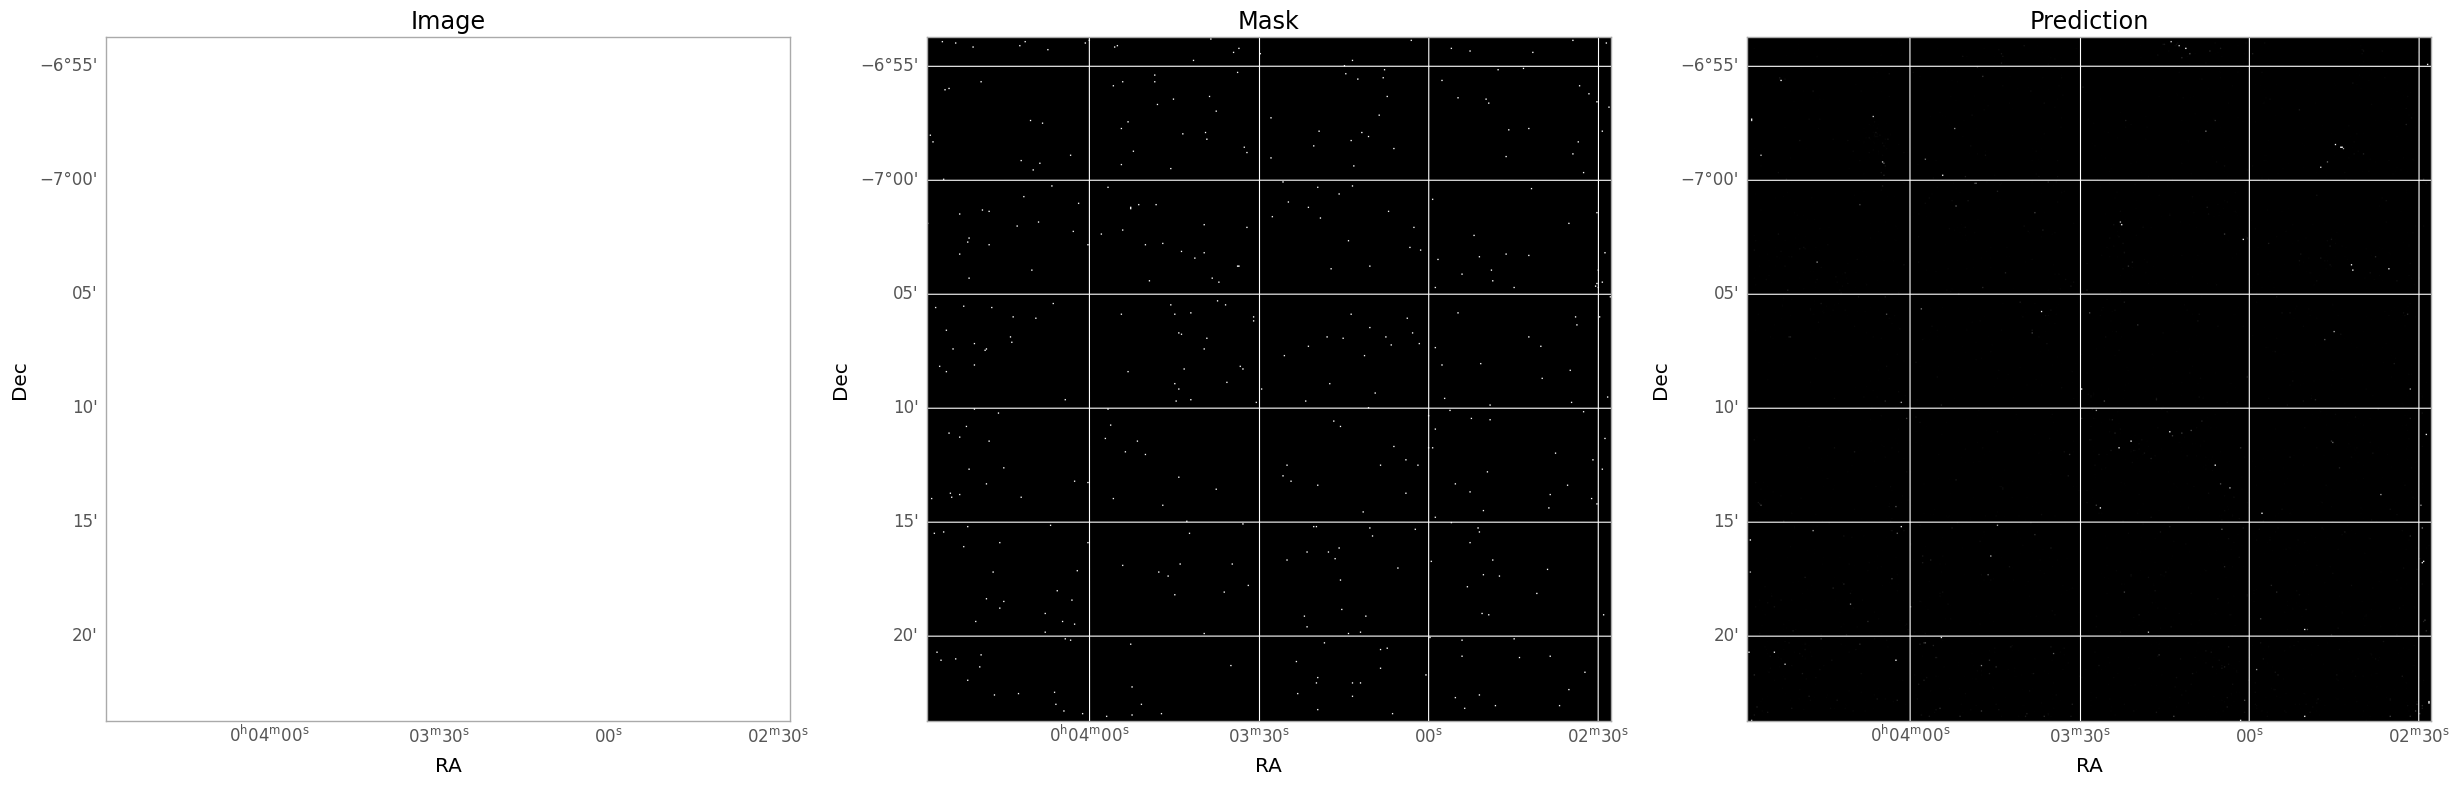

In [61]:
# Plot a random image mask prediction from the test set
selection = np.random.randint(0, len(new_images))
plot_image_mask_prediction_subplot(selection)


In [42]:
# Create a function to save the image, mask, and prediction to a file
def save_image_mask_prediction_subplot(selection = 0):
    """
    Saves the image, mask, and prediction for a given selection index to a file.
    Parameters:
    selection (int): The index of the image, mask, and prediction to save. Default is 0.
    file_path (str): The path to save the image, mask, and prediction to. Default is 'data["selection"].png'.
    The function extracts the image, mask, and prediction arrays using the provided selection index.
    It then creates a figure with three subplots, each displaying the image, mask, and prediction respectively.
    The subplots are saved to the specified file path.
    """
    image = new_images_normalized[selection]
    mask = new_masks[selection]
    pred_mask = model.predict(np.expand_dims(image, axis=0))[0]
    # Normalize the prediction mask to be between 0 and 1
    pred_mask_normalized = (pred_mask - pred_mask.min()) / (pred_mask.max() - pred_mask.min())
    wcs = wcs_data[selection]

    fig, ax = plt.subplots(1, 3, figsize=(30, 10), subplot_kw={'projection': wcs})
    ax[0].imshow(image, cmap='gray', origin='lower')
    ax[0].set_title('Image')
    ax[0].coords.grid(True, color='white', ls='solid')
    ax[0].coords[0].set_axislabel('RA')
    ax[0].coords[1].set_axislabel('Dec')

    ax[1].imshow(mask[:, :, 0], cmap='gray', origin='lower')
    ax[1].set_title('Mask')
    ax[1].coords.grid(True, color='white', ls='solid')
    ax[1].coords[0].set_axislabel('RA')
    ax[1].coords[1].set_axislabel('Dec')

    ax[2].imshow(pred_mask_normalized[:, :, 0], cmap='gray', origin='lower')
    ax[2].set_title('Prediction')
    ax[2].coords.grid(True, color='white', ls='solid')
    ax[2].coords[0].set_axislabel('RA')
    ax[2].coords[1].set_axislabel('Dec')

    image_title = fits_files[selection] + " Image, Mask, and Prediction"
    plt.suptitle(image_title, fontsize=24)

    file_path = 'results/figures/prediction_subplot/' + fits_files[selection].replace('.fits', '.png')

    print(f'Saving image, mask, and prediction to {file_path}')

    plt.savefig(file_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Saving image, mask, and prediction to results/figures/prediction_subplot/validate39.png


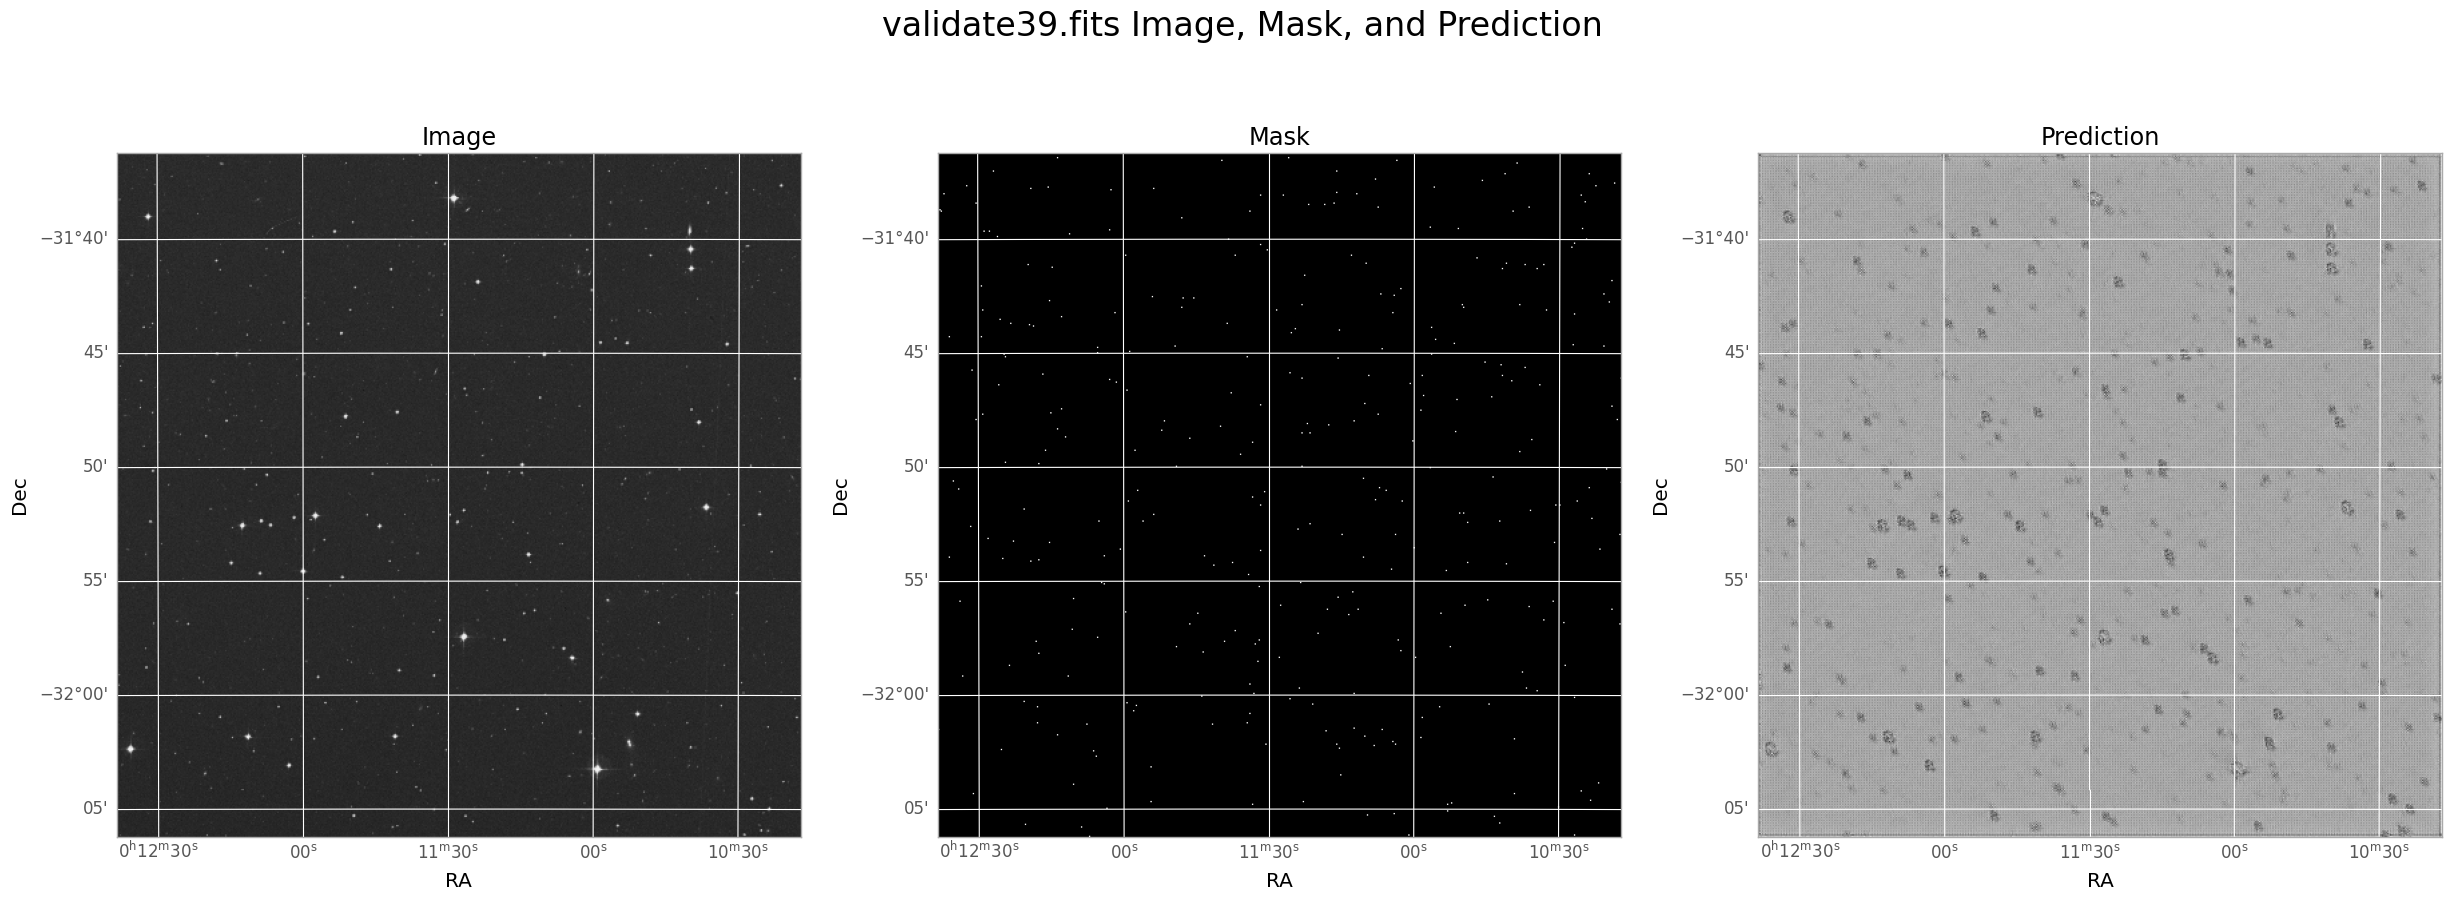

In [43]:
# Plot a random image mask prediction from the test set
choice = np.random.randint(0, len(new_images))
save_image_mask_prediction_subplot(selection = choice)

In [62]:
# I want to observe the prediction array to analyze the data and see what the model is predicting
# They are respresented as an array of values between 0 and 1 for likelihood of a star being present
# I will need to build a function to extract the star data from the prediction array
# I will need to set a threshold for the likelihood of a star being present
# I will need to extract the star data from the prediction array

def extract_star_predictions(prediction, threshold=0.5):
    """
    Extract the star data from the prediction array based on a threshold value and create a prediction mask.

    Parameters:
    ----------
    prediction : np.ndarray
        The prediction array to extract the star data from.
    threshold : float, optional
        The threshold value to determine if a pixel is a star (default is 0.5).

    Returns:
    -------
    star_data : list
        A list of tuples containing the (x, y) coordinates of the stars.
    prediction_mask : np.ndarray
        An array of 1's and 0's indicating the star locations.
    """
    # Normalize the prediction array to be between 0 and 1
    prediction = (prediction - prediction.min()) / (prediction.max() - prediction.min())

    # Ensure the prediction array is 2D
    if prediction.ndim == 3:
        prediction = prediction[:, :, 0]

    # Threshold the prediction array to get the star locations
    stars = np.argwhere(prediction > threshold)

    # Create a list to store the star data
    star_data = []

    # Create a prediction mask of the same shape as the prediction array
    prediction_mask = np.zeros_like(prediction, dtype=int)

    # Iterate over the star locations and add them to the star data list and prediction mask
    for star in stars:
        y, x = star
        star_data.append((x, y))
        prediction_mask[y, x] = 1

    return star_data, prediction_mask

In [67]:
selection = 0
image = new_images[selection]
mask = new_masks[selection]
pred_mask = model.predict(np.expand_dims(image, axis=0))[0]

# Check the shape of the prediction
print(f"Prediction shape: {pred_mask.shape}")  # Should be (512, 512, 1)

# Extract star predictions
pred_star_data, prediction_mask = extract_star_predictions(pred_mask, threshold=0.13)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction shape: (512, 512, 1)


In [68]:
prediction_mask
# Count all values in the prediction mask that are 1
np.count_nonzero(prediction_mask)

1372

In [69]:
np.count_nonzero(mask)

2592

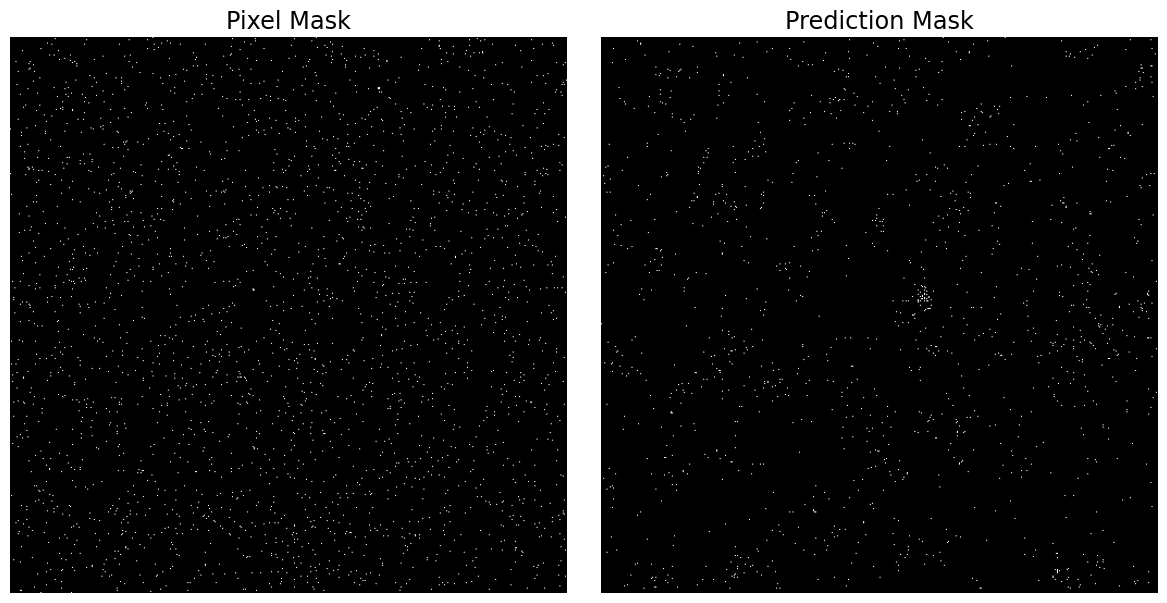

In [70]:
# Compare the prediction mask with the pixel mask
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.title('Pixel Mask')

plt.subplot(1, 2, 2)
plt.imshow(prediction_mask, cmap='gray')
plt.axis('off')
plt.title('Prediction Mask')

plt.tight_layout()
plt.show()

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from matplotlib.patches import Circle
from matplotlib.legend_handler import HandlerPatch

def plot_prediction_overlay(selection=0, threshold=0.10):
    """
    Plot the image with overlayed blue circles where the mask has 1's and red circles where the prediction is predicting the star locations.

    Parameters:
    ----------
    selection : int, optional
        The index of the image to plot (default is 0).
    """

    image = new_images[selection]
    mask = new_masks[selection]
    stars = stars_in_image[selection]
    pred_star_data, prediction_mask = extract_star_predictions(model.predict(np.expand_dims(image, axis=0))[0], threshold=threshold)
    print(np.count_nonzero(prediction_mask))
    wcs = wcs_data[selection]


    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection=wcs)


    # Draw blue circles on the image for pixel mask
    x_dim = wcs.pixel_shape[0]
    y_dim = wcs.pixel_shape[1]

    # Pixel-mask of stars
    pixel_mask = np.zeros((x_dim, y_dim))

    print('Drawing')  # DEBUG

    for star in stars:
        pixel_coords = getPixelCoordsFromStar(star, wcs)
        # pixel_mask[int(np.round(pixel_coords[0]))][int(np.round(pixel_coords[1]))] = 1
        # Ensure the pixel coordinates are within bounds
        x, y = int(np.round(pixel_coords[0])), int(np.round(pixel_coords[1]))
        if 0 <= x < x_dim and 0 <= y < y_dim:
            pixel_mask[x][y] = 1

        Drawing_colored_circle = plt.Circle((pixel_coords[0], pixel_coords[1]), 3, fill=False, edgecolor='blue', linewidth=0.75)
        ax.add_artist(Drawing_colored_circle)

    # Plot the image
    ax.imshow(image, cmap='gray', origin='lower')

    # Draw red circles on the image for star predictions
    x_dim = wcs.pixel_shape[0]
    y_dim = wcs.pixel_shape[1]

    # Pixel-mask of stars
    pixel_mask = np.zeros((x_dim, y_dim))

    print('Drawing')  # DEBUG

    for star in pred_star_data:
        pixel_coords = star
        # pixel_mask[int(np.round(pixel_coords[0]))][int(np.round(pixel_coords[1]))] = 1
        # Ensure the pixel coordinates are within bounds
        x, y = int(np.round(pixel_coords[0])), int(np.round(pixel_coords[1]))
        if 0 <= x < x_dim and 0 <= y < y_dim:
            pixel_mask[x][y] = 1

        Drawing_colored_circle = plt.Circle((pixel_coords[0], pixel_coords[1]), 4, fill=False, edgecolor='red', linewidth=0.2)
        ax.add_artist(Drawing_colored_circle)

    ax.set_title(f'{fits_files[selection] + " with Star Location and Star Prediction Overlays"}')
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.grid(color='white', ls='dotted')

    # Add legend
    def make_legend_circle(legend, orig_handle, xdescent, ydescent, width, height, fontsize):
        return Circle((width / 2, height / 2), 0.5 * height, fill=False, edgecolor=orig_handle.get_edgecolor(), linewidth=orig_handle.get_linewidth())


    # Display a legend for the circles
    blue_circle = Circle((0, 0), 1, fill=False, edgecolor='blue', linewidth=1)
    red_circle = Circle((0, 0), 1, fill=False, edgecolor='red', linewidth=1)
    ax.legend([blue_circle, red_circle], ['Star Location', 'Star Prediction'], loc='upper right', handler_map={Circle: HandlerPatch(patch_func=make_legend_circle)})


    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
723
Drawing


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [2028.0..14401.0].


Drawing


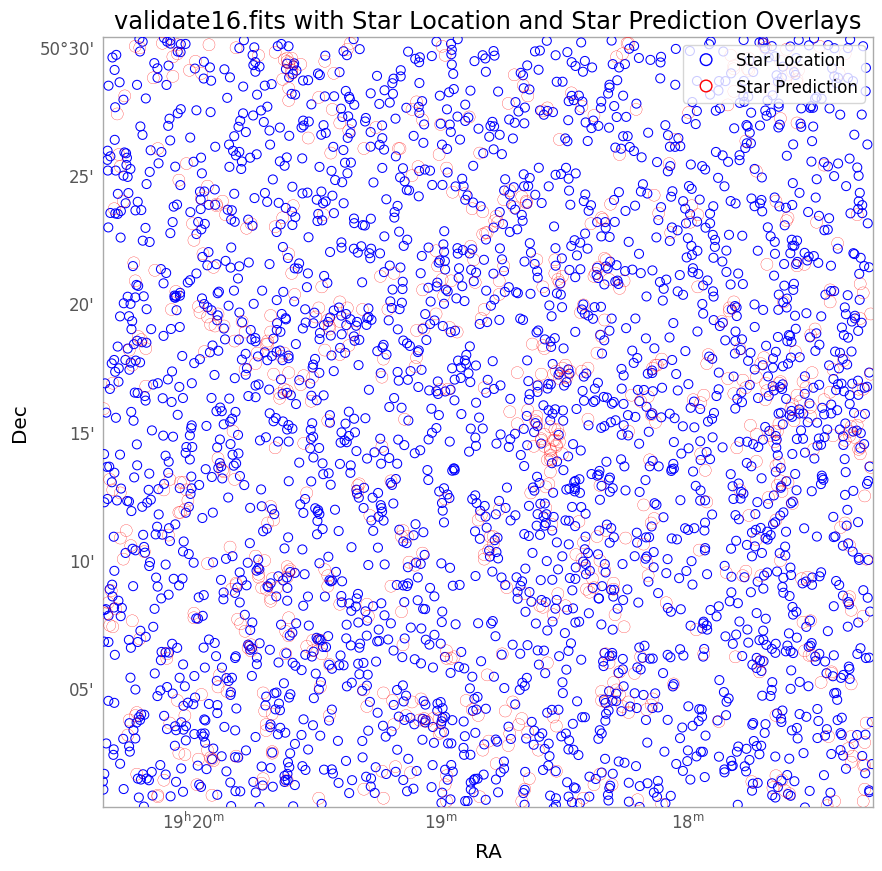

In [73]:
# Plot the image with overlayed mask and prediction
plot_prediction_overlay(0, threshold=0.29)

In [51]:
# Create a function to save the image with overlayed mask and prediction to a file
def save_image_mask_prediction_overlay(selection=0, threshold=0.10):
    """
    Save the image with overlayed blue circles where the mask has 1's and red circles where the prediction is predicting the star locations to a file.

    Parameters:
    ----------
    selection : int, optional
        The index of the image to save (default is 0).
    file_path : str, optional
        The path to save the image to (default is 'data["selection"].png').
    """

    image = new_images_normalized[selection]
    mask = new_masks[selection]
    stars = stars_in_image[selection]
    pred_star_data, prediction_mask = extract_star_predictions(model.predict(np.expand_dims(image, axis=0))[0], threshold=threshold)
    print(np.count_nonzero(prediction_mask))
    wcs = wcs_data[selection]


    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection=wcs)


    # Draw blue circles on the image for pixel mask
    x_dim = wcs.pixel_shape[0]
    y_dim = wcs.pixel_shape[1]

    # Pixel-mask of stars
    pixel_mask = np.zeros((x_dim, y_dim))

    print('Drawing')  # DEBUG

    for star in stars:
        pixel_coords = getPixelCoordsFromStar(star, wcs)
        # pixel_mask[int(np.round(pixel_coords[0]))][int(np.round(pixel_coords[1]))] = 1
        # Ensure the pixel coordinates are within bounds
        x, y = int(np.round(pixel_coords[0])), int(np.round(pixel_coords[1]))
        if 0 <= x < x_dim and 0 <= y < y_dim:
            pixel_mask[x][y] = 1

        Drawing_colored_circle = plt.Circle((pixel_coords[0], pixel_coords[1]), 3, fill=False, edgecolor='blue', linewidth=0.75)
        ax.add_artist(Drawing_colored_circle)

    # Plot the image
    ax.imshow(image, cmap='gray', origin='lower')

    # Draw red circles on the image for star predictions
    x_dim = wcs.pixel_shape[0]
    y_dim = wcs.pixel_shape[1]

    # Pixel-mask of stars
    pixel_mask = np.zeros((x_dim, y_dim))

    print('Drawing')  # DEBUG

    for star in pred_star_data:
        pixel_coords = star
        # pixel_mask[int(np.round(pixel_coords[0]))][int(np.round(pixel_coords[1]))] = 1
        # Ensure the pixel coordinates are within bounds
        x, y = int(np.round(pixel_coords[0])), int(np.round(pixel_coords[1]))
        if 0 <= x < x_dim and 0 <= y < y_dim:
            pixel_mask[x][y] = 1

        Drawing_colored_circle = plt.Circle((pixel_coords[0], pixel_coords[1]), 4, fill=False, edgecolor='red', linewidth=0.2)
        ax.add_artist(Drawing_colored_circle)

    image_title = fits_files[selection] + " with Star Location and Star Prediction Overlays" 
    ax.set_title(f'{image_title}')
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.grid(color='white', ls='dotted')

    # Add legend
    def make_legend_circle(legend, orig_handle, xdescent, ydescent, width, height, fontsize):
        return Circle((width / 2, height / 2), 0.5 * height, fill=False, edgecolor=orig_handle.get_edgecolor(), linewidth=orig_handle.get_linewidth())


    # Display a legend for the circles
    blue_circle = Circle((0, 0), 1, fill=False, edgecolor='blue', linewidth=1)
    red_circle = Circle((0, 0), 1, fill=False, edgecolor='red', linewidth=1)
    ax.legend([blue_circle, red_circle], ['Star Location', 'Star Prediction'], loc='upper right', handler_map={Circle: HandlerPatch(patch_func=make_legend_circle)})


    file_path = 'results/figures/prediction_overlay/' + fits_files[selection].replace('.fits', '.png')

    print(f'Saving image with mask and prediction overlays to {file_path}')

    plt.savefig(file_path)

In [52]:
# # Save a random image mask prediction from the test set
# choice = np.random.randint(0, len(new_images))
# save_image_mask_prediction_overlay(selection=choice)

In [53]:
# # Iterate over the test set and save the image with overlayed mask and prediction to a file
# for i in range(len(new_images)):
#     save_image_mask_prediction_subplot(selection=i)
#     save_image_mask_prediction_overlay(selection=i)